In [1]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
from sklearn.cluster import KMeans
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from skimage import exposure
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure
from skimage.feature import hog


In [2]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [3]:
class_mapping = {
    0: 0,  # T-shirt/top
    1: 1,  # Trouser
    2: 0,  # Pullover
    3: 3,  # Dress
    4: 0,  # Coat
    5: 2,  # Sandal
    6: 0,  # Shirt
    7: 2,  # Sneaker
    8: 4,  # Bag
    9: 2   # Ankle boot
}
train_labels = np.vectorize(class_mapping.get)(train_labels)
test_labels = np.vectorize(class_mapping.get)(test_labels)

In [4]:
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [5]:
# Reshape images to flat vectors
# train_images_flat = train_images.reshape((60000, -1))
# test_images_flat = test_images.reshape((10000, -1))

In [6]:
def compute_hog_features(image):
    features, hog_image = hog(image, visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    return features, hog_image_rescaled

In [7]:
hog_features = []
hog_images=[]
for img in train_images:
    features, hog_image= compute_hog_features(img)
    hog_images.append(hog_image)
    hog_features.append(features)

In [8]:
test_hog_features = []
test_hog_image=[]
for img in test_images:
    features, hog_image= compute_hog_features(img)
    test_hog_image.append(hog_image)
    test_hog_features.append(features)

In [9]:
# Convert labels to one-hot encoding
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

In [10]:
hog_features_flat = np.reshape(hog_features, (len(hog_features), -1))
test_hog_features_flat = np.reshape(test_hog_features, (len(test_hog_features), -1))


In [11]:
# Apply k-means clustering
#num_clusters = 5  # Number of clusters (number of classes in Fashion MNIST)
lr = LogisticRegression(max_iter=200)
history=lr.fit(hog_features_flat,train_labels)
#kmeans = KMeans(n_clusters=num_clusters, random_state=42)
#kmeans.fit(train_images_flat)

In [12]:
# Assign cluster labels
#train_cluster_labels = kmeans.predict(train_images_flat)
#test_cluster_labels = kmeans.predict(test_images_flat)
print(lr.score(test_hog_features_flat,test_labels))
print(lr.score(hog_features_flat,train_labels))
test_predictions=lr.predict(test_hog_features)

0.9488
0.9538333333333333


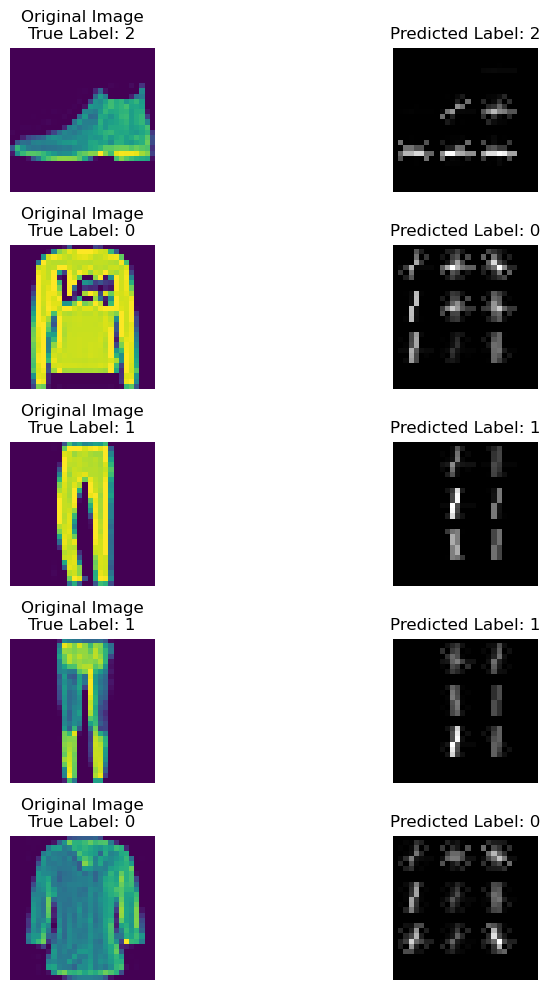

In [13]:
num_samples = 5  # Number of samples to visualize

fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))

for i in range(num_samples):
    # Plot original image
    axes[i, 0].imshow(test_images[i])
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f'Original Image\nTrue Label: {test_labels[i]}')

    # Plot HOG feature
    axes[i, 1].imshow(test_hog_image[i], cmap=plt.cm.gray)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f'Predicted Label: {test_predictions[i]}')

plt.tight_layout()
plt.show()


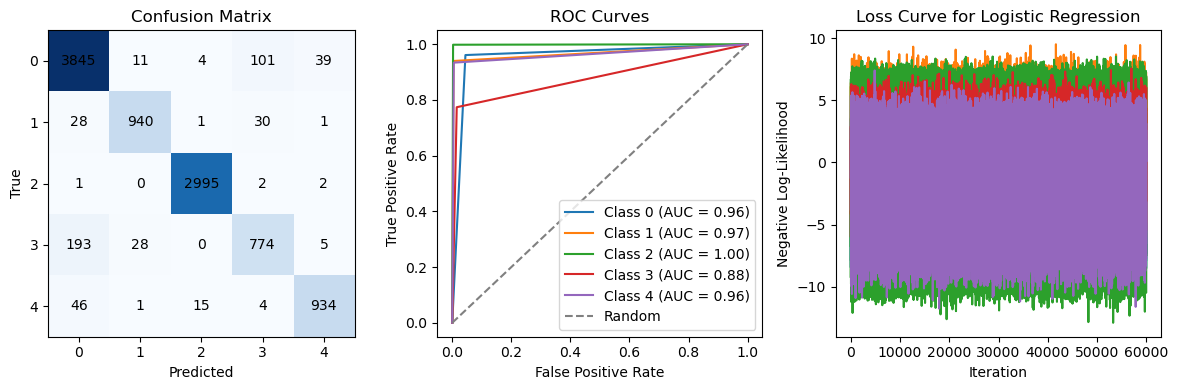

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
# Plot results

# Evaluate the model on test data
test_predictions = lr.predict(test_hog_features_flat)
accuracy = accuracy_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Compute ROC-AUC for each class
num_classes = len(np.unique(train_labels))
test_labels_bin = label_binarize(test_labels, classes=range(num_classes))
test_predictions_bin = label_binarize(test_predictions, classes=range(num_classes))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot results including the loss curve
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot confusion matrix
axes[0].imshow(conf_matrix, cmap='Blues', interpolation='nearest')
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_xticks(range(5))
axes[0].set_yticks(range(5))
for i in range(5):
    for j in range(5):
        axes[0].text(j, i, str(conf_matrix[i, j]), ha='center', va='center')

# Plot ROC curves
axes[1].set_title('ROC Curves')
for i in range(num_classes):
    axes[1].plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].legend()


# Plot the loss curve
loss_values = -np.array(history.decision_function(hog_features_flat))
axes[2].plot(loss_values, label='Training Loss')
axes[2].set_title('Loss Curve for Logistic Regression')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Negative Log-Likelihood')  # Use negative accuracy as a proxy for loss



plt.tight_layout()
plt.show()